# Task 2
Setup a NN to regress aco_angle_1 - this will give us some ideas about how we need to setup the NN in order for it to make use of the low-level information and then we can use a similar architecture for our final NN setup. After reading around online a bit one possible reason that the NN is not working very well is because the CP observables depend on what rest frame you determine them in and possibly the NN is not well setup to handle Lorentz boosts into different frames. I found a paper which suggest how to setup the first layers of a NN in order to perform such Lorentz boosts (https://arxiv.org/pdf/1812.09722.pdf) - this might be a good place to start, but of course if you have other ideas you are free to follow them

In [49]:
import uproot 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#from pylorentz import Momentum4
#from pylorentz import Position4
from lbn import LBN, LBNLayer

In [65]:
# stop tensorflow trying to overfill GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
#tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
#tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [13]:
# define what variables are to be read into the dataframe

momenta_features = [ "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", #leading charged pi 4-momentum
              "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", #subleading charged pi 4-momentum
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1", #leading neutral pi 4-momentum
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2"] #subleading neutral pi 4-momentum

other_features = [ "ip_x_1", "ip_y_1", "ip_z_1",        #leading impact parameter
                   "ip_x_2", "ip_y_2", "ip_z_2",        #subleading impact parameter
                   "y_1_1", "y_1_2"]    # ratios of energies

target = [    "aco_angle_1"]  #acoplanarity angle
    
selectors = [ "tau_decay_mode_1","tau_decay_mode_2",
             "mva_dm_1","mva_dm_2"
             ]

df = tree.pandas.df(features+other_features+target+selectors)

df = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
]
#df2 = tree2.pandas.df(variables)

#tree3 should be more comprehensive and complete as it includes all decay types and more
#info for tau->a1 decays. Again we save the same variables for now

#df3 = tree3.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df,df2], ignore_index=True)

In [14]:
df.head()

,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,...,ip_x_2,ip_y_2,ip_z_2,y_1_1,y_1_2,aco_angle_1,tau_decay_mode_1,tau_decay_mode_2,mva_dm_1,mva_dm_2
entry,,,,,,,,,,,,,,,,,,,,,
4,26.184192,5.249920,-12.394966,-22.458754,52.305565,-10.016787,40.401790,-31.673523,95.932667,20.387663,...,-0.000894,0.000668,0.000903,0.571162,-0.773942,5.927902,1,1,1,1
15,3.912128,3.186334,0.086207,-2.263873,32.211659,7.872188,29.660602,9.790244,64.282235,52.942869,...,-0.002586,0.001020,-0.000611,0.885265,-0.339467,5.015406,1,1,1,1
26,20.389432,12.846308,15.714182,1.935544,5.313678,-4.517069,-2.251007,1.656731,35.041365,21.823335,...,0.004199,0.003093,0.014879,0.264328,0.760691,3.019532,1,1,1,1
39,4.532329,-1.060811,2.501133,-3.625128,11.348225,-2.284085,-6.326895,-9.138714,102.977036,-25.022726,...,0.009565,-0.000590,-0.001876,0.915685,0.772376,2.650678,1,1,1,1
55,77.929050,28.100279,42.522791,58.950012,72.891011,8.689332,15.745896,70.637400,68.260095,25.125369,...,-0.020295,0.027176,-0.004810,-0.066140,0.534360,3.057700,1,1,1,1


In [28]:
# Create x and y tensors
x = tf.convert_to_tensor(df[momenta_features], dtype="float32")

# Reshape for LBN
x = tf.reshape(x, (x.shape[0], 4, 4))

# Normalise input:
#x = (x - tf.math.reduce_mean(x,axis = 0))/tf.math.reduce_std(x, axis=0)

y = tf.convert_to_tensor(df[target], dtype="float32")

In [60]:
#features for LBN output
LBN_output_features = ["E", "px", "py", "pz", "m", "pair_dy", "pair_cos"]

#define NN model and compile
model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten( input_shape=(24,)),
    LBNLayer((4, 4), 50, boost_mode=LBN.PAIRS, features=LBN_output_features),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['mse'])

In [61]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LBN (LBNLayer)               (None, 2700)              400       
_________________________________________________________________
dense_23 (Dense)             (None, 300)               810300    
_________________________________________________________________
dense_24 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_25 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_26 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 301       
Total params: 1,081,901
Trainable params: 1,081,901
Non-trainable params: 0
___________________________________________

In [62]:
#train model
history = model.fit(x, y, validation_split=0.3, epochs=50)

Epoch 1/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3996 - mse: 3.3996 - val_loss: 3.3550 - val_mse: 3.3550
Epoch 2/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3365 - mse: 3.3365 - val_loss: 3.3712 - val_mse: 3.3712
Epoch 3/50
3183/3183 [==============================] - 16s 5ms/step - loss: 3.3149 - mse: 3.3149 - val_loss: 3.2999 - val_mse: 3.2999
Epoch 4/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3159 - mse: 3.3159 - val_loss: 3.3041 - val_mse: 3.3041
Epoch 5/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3071 - mse: 3.3071 - val_loss: 3.3090 - val_mse: 3.3090
Epoch 6/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3053 - mse: 3.3053 - val_loss: 3.3152 - val_mse: 3.3152
Epoch 7/50
3183/3183 [==============================] - 17s 5ms/step - loss: 3.3052 - mse: 3.3052 - val_loss: 3.3008 - val_mse: 3.3008
Epoch 8/50
3183/3183 [==============================] -

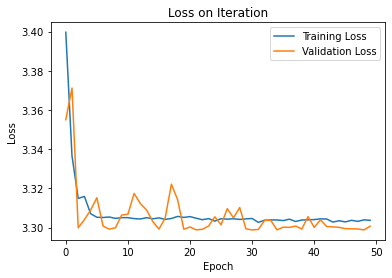

In [63]:
#plot traning
plt.figure()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss on Iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [66]:
#Infer on full dataset
#TODO: only infer on validation set
Phi_CP = np.array(model(x))

#Plot the histogram
aco_angle_1 = np.array(df['aco_angle_1'])

plt.figure()
plt.title("Rho decay acoplanarity angles")
plt.hist(Phi_CP, label="My Calculation", alpha=0.625, bins=50)
plt.hist(aco_angle_1, label="From .root", alpha=0.625, bins=50)
plt.xlabel(r"$\phi_{CP}$")
plt.ylabel("Frequency")
plt.grid()
plt.legend()
plt.savefig("KingsleyTask1.png")
plt.show()
plt.close()

ResourceExhaustedError: OOM when allocating tensor with shape[145487,50,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: particles_pvec

In [49]:
#print the first few results vs given angles
for i in range(10):
    print("{:.4f} \t {:.4f}".format(Phi_CP[i], aco_angle_1[i]))

5.9279 	 5.9279
5.0154 	 5.0154
0.1221 	 3.0195
0.4909 	 2.6507
3.0577 	 3.0577
4.0362 	 5.3886
4.3666 	 5.0581
3.4759 	 3.4759
3.7483 	 5.6765
4.7794 	 4.6454


In [53]:
(Phi_CP - aco_angle_1)[:10]

array([ 1.68753900e-14,  1.15463195e-14, -2.89747202e+00, -2.15976258e+00,
        1.88737914e-13, -1.35242812e+00, -6.91484309e-01, -5.77315973e-15,
       -1.92823855e+00,  1.34072471e-01])

In [55]:
residuals = (Phi_CP - aco_angle_1)
print("Incorrect {:.2f}% of the time".format(100*np.count_nonzero(np.round(residuals, 4))/len(residuals)))

Incorrect 48.82% of the time


In [56]:
#print first few residuals
for i in range(10):
    print("{:.4f}".format(residuals[i]))

0.0000
0.0000
-2.8975
-2.1598
0.0000
-1.3524
-0.6915
-0.0000
-1.9282
0.1341
